# Feature Engineering

In [1]:
# import library
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
# load data
hotel = pd.read_csv('hotel_bookings_no_missing.csv',index_col='Unnamed: 0')

## Feature Engineering

In [3]:
# to check the feature types
hotel.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_month                 object
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                            int64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
days_in_waiting_list                int64
customer_type                      object
adr                               

## Handling categorical features

In [4]:
# change hotels to 0 and 1 (City Hotel: 1, Resort Hotel: 0)
hotel['hotel'] = hotel.hotel.replace(['Resort Hotel','City Hotel'],[0,1])

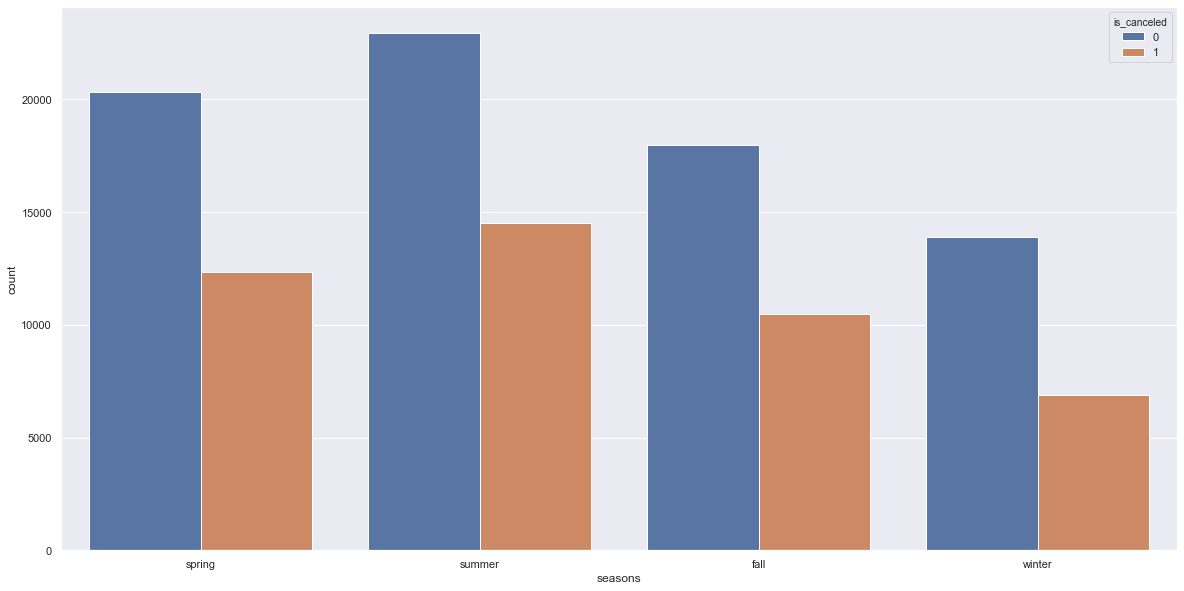

In [5]:
month=['January', 'February', 'March', 'April', 'May', 'June', 'July', 
       'August', 'September', 'October', 'November', 'December']
# change arrival date month to 1 to 12
hotel['arrival_date_month'] = hotel.arrival_date_month.replace(month,np.arange(1,13))

# group months into seasons
spring = [3,4,5]
summer = [6,7,8]
fall = [9,10,11]
winter = [1,2,12]
hotel['seasons'] = hotel['arrival_date_month'].map(lambda i: "spring" if i in spring 
                                                   else "summer" if i in summer 
                                                   else "fall" if i in fall 
                                                   else "winter")

# bar chart for seasons
plt.figure(figsize=(20,10))
seasons = ['spring','summer','fall','winter']
sns.countplot(x = 'seasons', hue = 'is_canceled', data=hotel, order=seasons)

In [6]:
# create one-hot variavles for seasons
season_dummy = pd.get_dummies(hotel['seasons'])

In [7]:
# create one-hot variavles for meal
meal_dummy = pd.get_dummies(hotel['meal'],prefix ='meal')

In [8]:
# Finding the most predictive country with >80% majority label and more than 5000 entries

# Groupby country and find how many cancelled and not cancelled each country has
country_count = hotel.groupby(['country','is_canceled'])['is_canceled'].size().reset_index(name='count_cancelled')
# hotelcountrysum= hotel.groupby('country')['is_canceled'].agg(pd.Series.sum).reset_index(name='sum') 
country_sum = hotel.groupby('country')['is_canceled'].count().reset_index(name='sum')
# left join the sum and count
country_joined= country_count.merge(country_sum, on='country', how='left')
# finding the percentage of each label in a country
country_joined['percentage'] = country_joined.apply(lambda x: x['count_cancelled']/x['sum'], axis=1)
# remove all countires whose majority label is less than 80%
country_joined = country_joined[country_joined['percentage'] > 0.8]
# remove all countries whose sum is less than 5000
country_joined = country_joined[country_joined['sum'] > 5000]

# most predictive countries. With >80% majority label and more than 5000 entries
country_joined

,country,is_canceled,count_cancelled,sum,percentage
69,DEU,0,6069,7287,0.832853
92,FRA,0,8481,10415,0.814306


In [9]:
# FRA and DEU are the most predictive countries so they would be the dummy variables
hotel['country_is_FRA'] = hotel['country'].apply(lambda x: 1 if x == 'FRA' else 0)
hotel['country_is_DEU'] = hotel['country'].apply(lambda x: 1 if x == 'DEU' else 0)
hotel['country_is_other'] = hotel['country'].apply(lambda x: 1 if (x != 'DEU' and x!='FRA') else 0)

In [10]:
# create one-hot variavles for market_segment
market_segment_dummy = pd.get_dummies(hotel['market_segment'],prefix ='market_segment')

In [11]:
# create one-hot variavles for distribution_channel
distribution_channel_dummy = pd.get_dummies(hotel['distribution_channel'],prefix ='distribution_channel')

In [12]:
# create one-hot variavles for deposit_type
deposit_type_dummy = pd.get_dummies(hotel['deposit_type'],prefix='deposit_type')

In [13]:
# Hypothesis: If reserved room type matches assigned room type, i.e. reserved_assigned_room_type_match = 1, it is more likely for the customer to NOT cancel the booking.
# check to see if reserved room type matches assigned room type
hotel['reserved_assigned_room_type_match'] = (hotel['reserved_room_type'] == hotel['assigned_room_type'])
match_dummy = pd.get_dummies(hotel['reserved_assigned_room_type_match'],prefix ='reserved_assigned_room_type_match')
hotel['reserved_assigned_room_type_match'] = match_dummy['reserved_assigned_room_type_match_True']

In [14]:
# create one-hot variavles for customer_type
cus_type_dummy = pd.get_dummies(hotel['customer_type'],prefix ='customer_type')

In [15]:
# adding dummy variables into the dataset
hotel = pd.concat([hotel,
                   season_dummy,
                   distribution_channel_dummy,
                   market_segment_dummy,
                   meal_dummy,
                   deposit_type_dummy,
                   cus_type_dummy
                  ],
                  axis=1,sort=True)

In [16]:
# feature - agent
hotel.groupby('is_canceled')['agent'].value_counts()

# Group by is_canceled and find the most frequent agent for each is_canceled
hotel.groupby('is_canceled')['agent'].agg(pd.Series.mode)

# Groupby agent and find how many cancelled and not cancelled each agent has
hotelAgentCount = hotel.groupby(['agent','is_canceled'])['is_canceled'].size().reset_index(name='count_cancelled')
hotelAgentSum = hotel.groupby('agent')['is_canceled'].count().reset_index(name='sum')
# left join the sum and count
hotelAgentJoined= hotelAgentCount.merge(hotelAgentSum, on='agent', how='left')

# finding the percentage of each label in an agent
hotelAgentJoined['percentage'] = hotelAgentJoined.apply(lambda x: x['count_cancelled']/x['sum'], axis=1)

# all agents whose majority label is more than 80% and sum is more than 3000
hotelAgentJoined80 = hotelAgentJoined[hotelAgentJoined['percentage'] > 0.8]
hotelAgentJoined3000 = hotelAgentJoined80[hotelAgentJoined80['sum'] > 3000]
hotelAgentJoined3000

,agent,is_canceled,count_cancelled,sum,percentage
14,7.0,0,3065,3539,0.866064
28,14.0,0,2988,3640,0.820879


In [17]:
# agent 7 and 14 are the most predictive agents so they would be the dummy variables
hotel['agent_14'] = hotel['agent'].apply(lambda x: 1 if x == 14.0 else 0)
hotel['agent_7'] = hotel['agent'].apply(lambda x: 1 if x == 7.0 else 0)
hotel['agent_is_other'] = hotel['agent'].apply(lambda x: 1 if (x != 14.0 and x!=7.0) else 0)

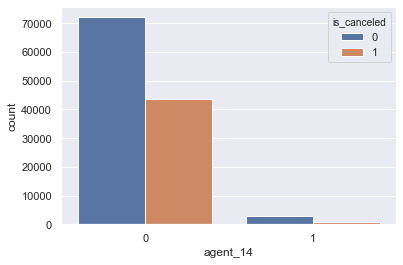

In [46]:
sns.countplot(x='agent_14',hue='is_canceled',data=hotel)

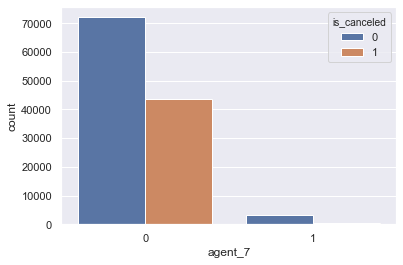

In [47]:
sns.countplot(x='agent_7',hue='is_canceled',data=hotel)

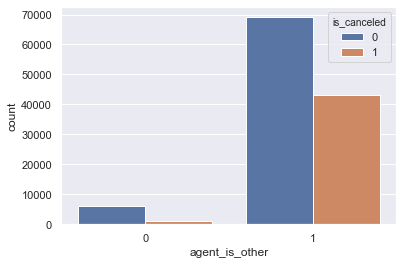

In [48]:
sns.countplot(x='agent_is_other',hue='is_canceled',data=hotel)

## Handling numerical features

In [21]:
from sklearn import preprocessing

**lead_time**

In [22]:
hotel['lead_time'].skew()

1.3465498727254268

In [23]:
hotel['log_lead'] = hotel['lead_time'].map(lambda i: np.log(i) if i > 0 else 0)
hotel['log_lead'].skew()

-0.903993835862541

Perform `log( )` function on each lead time to scale the data.  
After outliers handling:

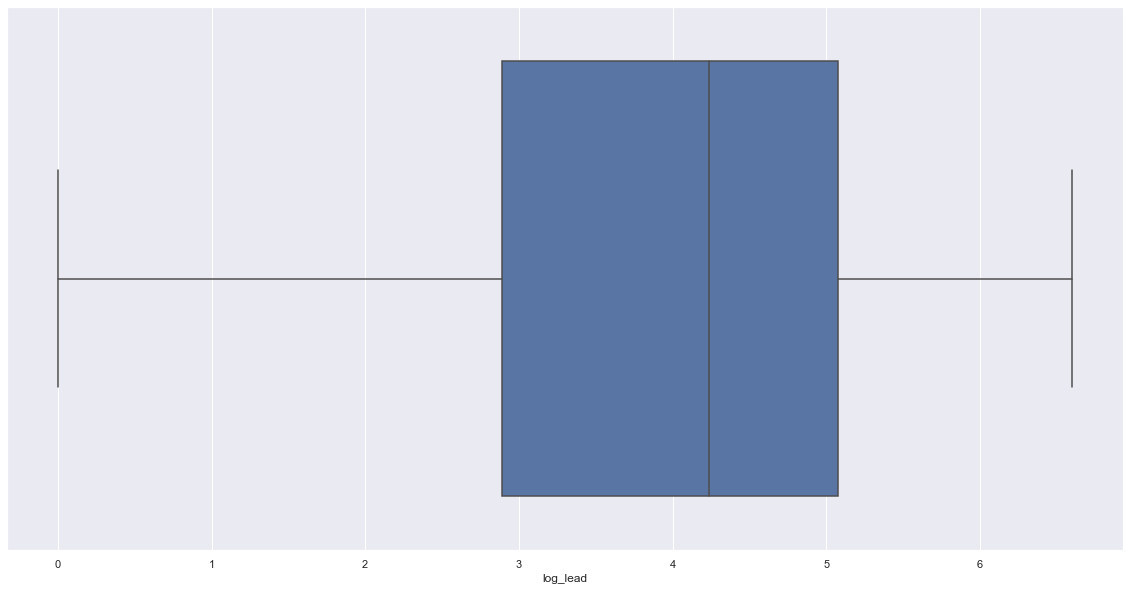

In [24]:
plt.figure(figsize = (20,10))
sns.boxplot(hotel['log_lead'])

**stays_in_weekend_nights**

In [25]:
hotel['stays_in_weekend_nights'] = np.where(hotel['stays_in_weekend_nights'] > 5, 5, hotel['stays_in_weekend_nights'])

Data clipping: for each `stays_in_weekend_nights`, if it is larger than 5, change it to 5.  
After outliers handling:

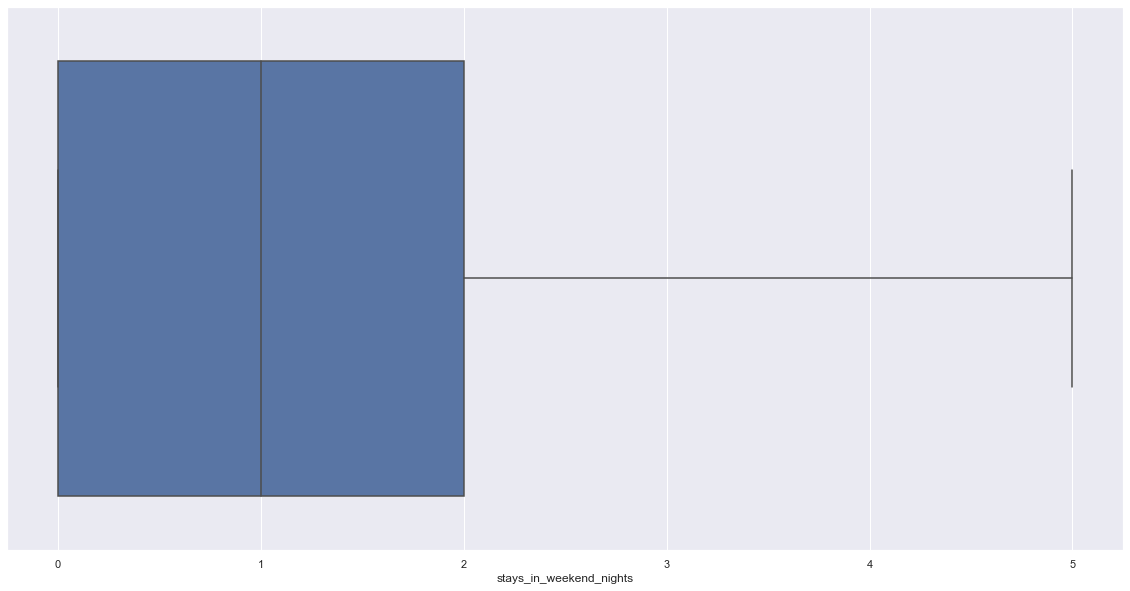

In [26]:
plt.figure(figsize = (20,10))
sns.boxplot(hotel['stays_in_weekend_nights'])

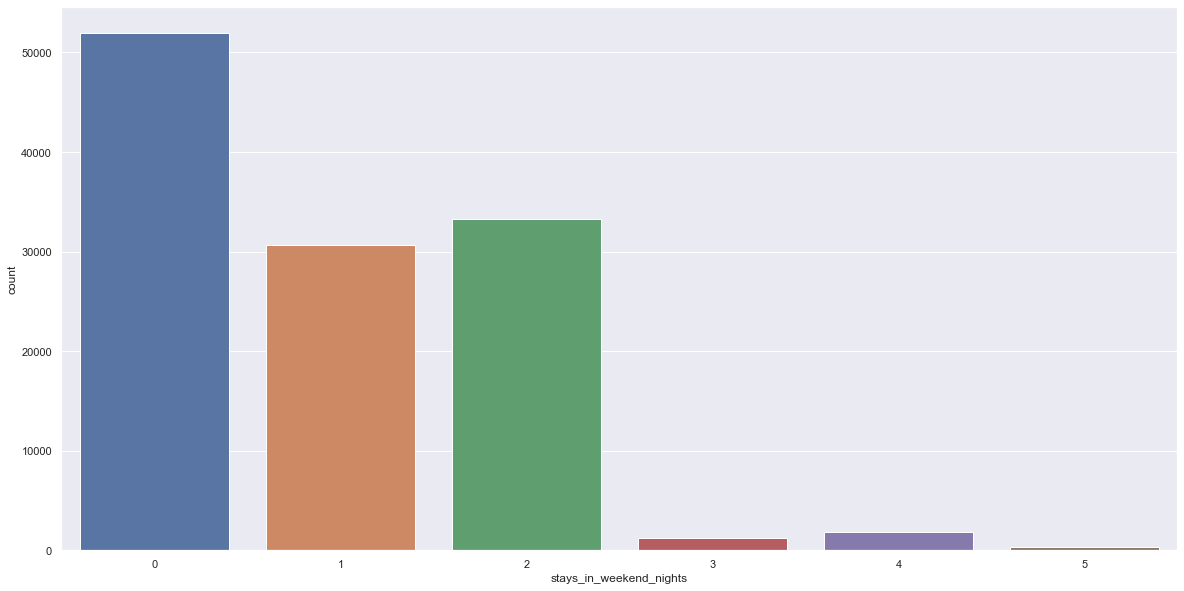

In [27]:
plt.figure(figsize = (20,10))
sns.countplot(hotel['stays_in_weekend_nights'])

**stays_in_week_nights**

In [28]:
hotel['stays_in_week_nights'] = np.where(hotel['stays_in_week_nights'] > 6, 6, hotel['stays_in_week_nights'])

Data clipping: for each `stays_in_weekend_nights`, if it is larger than 5, change it to 5.  
After outliers handling:

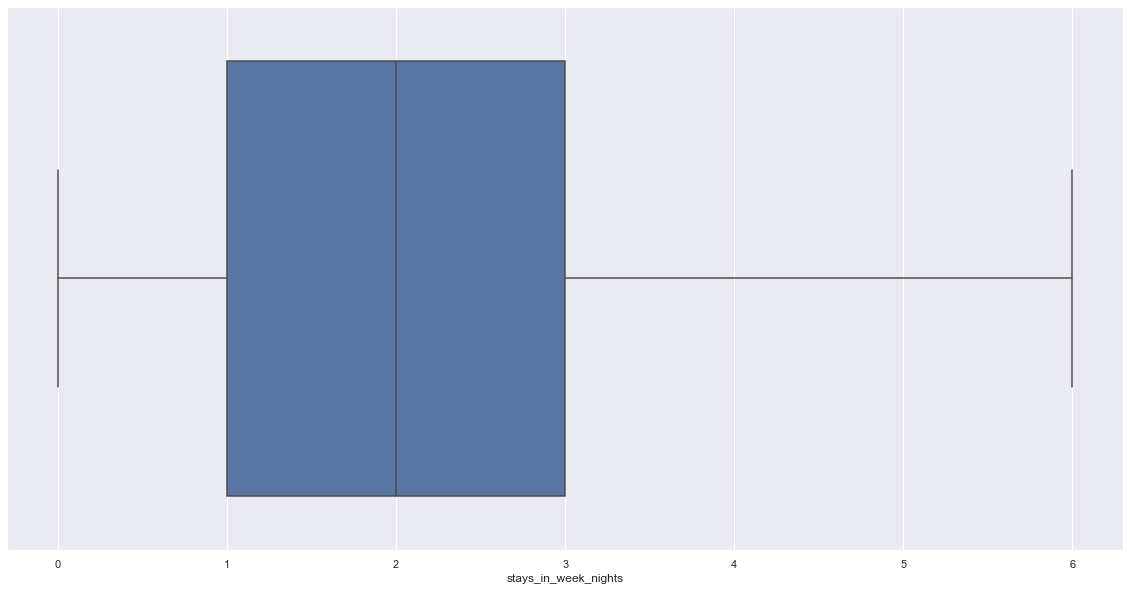

In [29]:
plt.figure(figsize = (20,10))
sns.boxplot(hotel['stays_in_week_nights'])

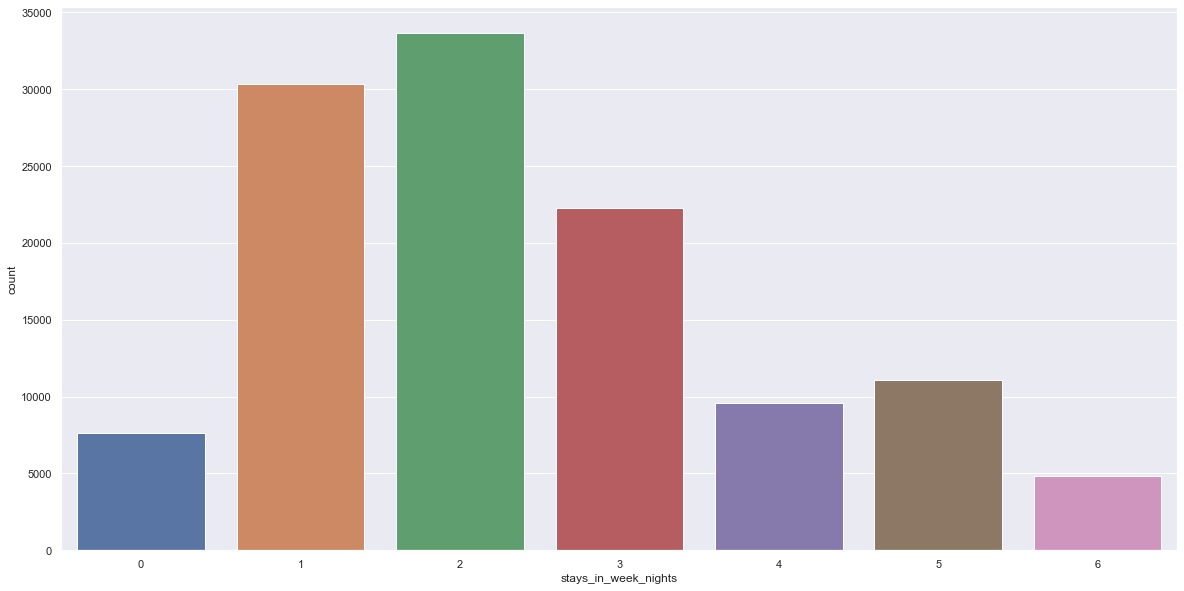

In [30]:
plt.figure(figsize = (20,10))
sns.countplot(hotel['stays_in_week_nights'])

**stays_in_total_nights**

In [31]:
# create a column indicates the total nights each customers stay
hotel['stays_in_total_nights'] = hotel['stays_in_weekend_nights'] + hotel['stays_in_week_nights']

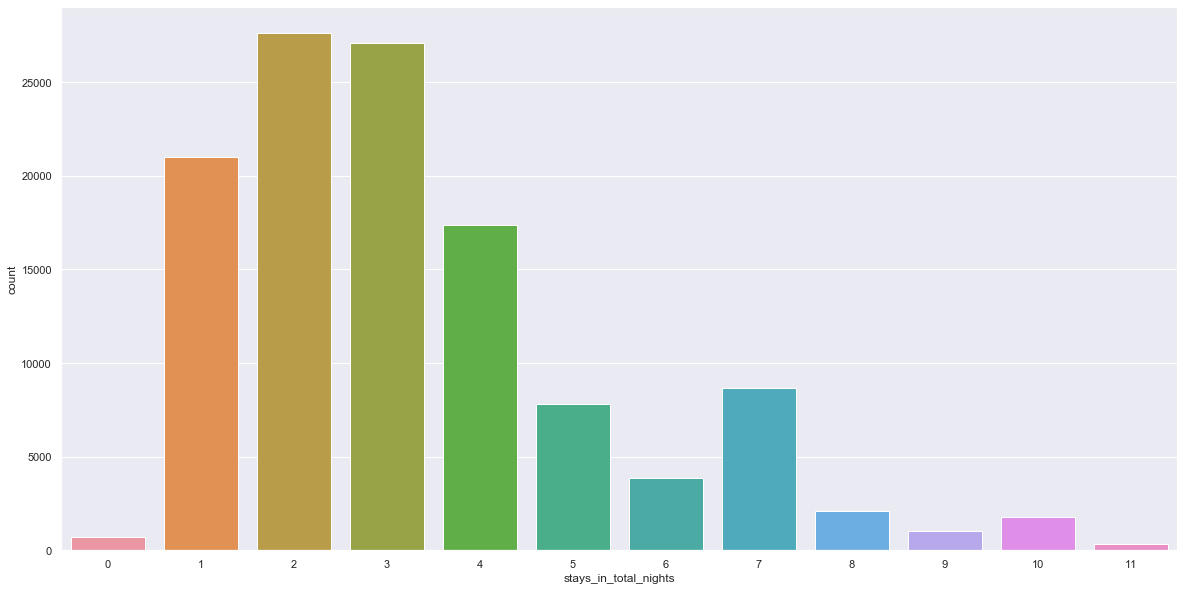

In [32]:
plt.figure(figsize = (20,10))
sns.countplot(hotel['stays_in_total_nights'])

**adr**

In [33]:
mean_adr = hotel['adr'].mean()
std_adr = hotel['adr'].std()
hotel['adr'] = np.where(hotel['adr'] > (mean_adr+10*std_adr), mean_adr, hotel['adr'])

Changing the outliers of `adr` to the data mean.

### Binning

In [34]:
# Put previous_cancellations into 4 categories
cut_labels_4 = ['0','1-10', '11-20', '21+']
cut_bins = [0, 0.1, 10, 20, 30]
hotel['cut_previous_cancellations'] = pd.cut(hotel['previous_cancellations'], include_lowest=True, bins=cut_bins, labels=cut_labels_4)
hotel.groupby('cut_previous_cancellations')['is_canceled'].value_counts()

cut_previous_cancellations  is_canceled
0                           0              74624
                            1              38282
1-10                        1               5788
                            0                516
11-20                       1                 54
                            0                 26
21+                         1                100
Name: is_canceled, dtype: int64

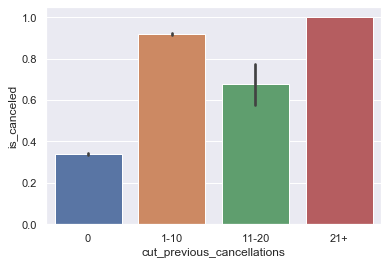

In [35]:
sns.barplot(x='cut_previous_cancellations',y='is_canceled',data=hotel)

In [36]:
# Put previous_bookings_not_canceled into 5 categories
cut_labels_5 = ['0','1-20', '21-40', '41-60', '60+']
cut_bins_previous_bookings_not_canceled = [0, 0.1, 20, 40, 60, 81]
hotel['cut_previous_bookings_not_canceled'] = pd.cut(hotel['previous_bookings_not_canceled'], include_lowest=True, bins=cut_bins_previous_bookings_not_canceled, labels=cut_labels_5)
hotel.groupby('cut_previous_bookings_not_canceled')['is_canceled'].value_counts()

cut_previous_bookings_not_canceled  is_canceled
0                                   0              71746
                                    1              44024
1-20                                0               3300
                                    1                185
21-40                               0                 88
                                    1                 12
41-60                               0                 20
                                    1                  3
60+                                 0                 12
Name: is_canceled, dtype: int64

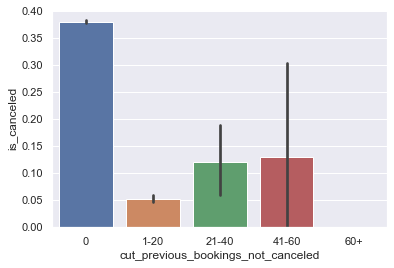

In [37]:
sns.barplot(x='cut_previous_bookings_not_canceled',y='is_canceled',data=hotel)

In [38]:
# Put booking_changes into 6 categories
cut_labels_6 = ['0','1-5', '6-10', '11-15', '16-20','21+']
cut_bins_booking_changes = [0, 0.1, 5, 10, 15, 20, 26]
hotel['cut_booking_changes'] = pd.cut(hotel['booking_changes'], bins=cut_bins_booking_changes, include_lowest=True, labels=cut_labels_6)
hotel.groupby('cut_booking_changes')['is_canceled'].value_counts()

cut_booking_changes  is_canceled
0                    0              59923
                     1              41391
1-5                  0              15123
                     1               2804
6-10                 0                 98
                     1                 27
11-15                0                 16
                     1                  1
16-20                0                  5
                     1                  1
21+                  0                  1
Name: is_canceled, dtype: int64

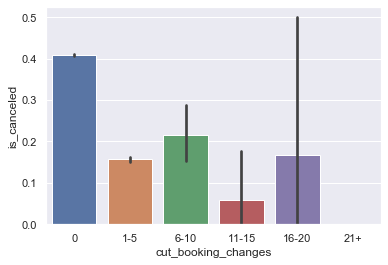

In [39]:
sns.barplot(x='cut_booking_changes',y='is_canceled',data=hotel)

### Normalization

In [40]:
# log_lead
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['log_lead']])
hotel['log_lead_minmax']=minmax_scaler.transform(hotel[['log_lead']])

# stays_in_weekend_nights
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['stays_in_weekend_nights']])
hotel['stays_in_weekend_nights_minmax']=minmax_scaler.transform(hotel[['stays_in_weekend_nights']])

# stays_in_week_nights
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['stays_in_week_nights']])
hotel['stays_in_week_nights_minmax']=minmax_scaler.transform(hotel[['stays_in_week_nights']])

# stays_in_total_nights
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['stays_in_total_nights']])
hotel['stays_in_total_nights_minmax']=minmax_scaler.transform(hotel[['stays_in_total_nights']])

# adults
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['adults']])
hotel['adults_minmax']=minmax_scaler.transform(hotel[['adults']])

# children
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['children']])
hotel['children_minmax']=minmax_scaler.transform(hotel[['children']])

# babies
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['babies']])
hotel['babies_minmax']=minmax_scaler.transform(hotel[['babies']])

# days_in_waiting_list
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['days_in_waiting_list']])
hotel['days_in_waiting_list_minmax']=minmax_scaler.transform(hotel[['days_in_waiting_list']])

# adr
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['adr']])
hotel['adr_minmax']=minmax_scaler.transform(hotel[['adr']])

# required_car_parking_spaces
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['required_car_parking_spaces']])
hotel['required_car_parking_spaces_minmax']=minmax_scaler.transform(hotel[['required_car_parking_spaces']])

# total_of_special_requests
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['total_of_special_requests']])
hotel['total_of_special_requests_minmax']=minmax_scaler.transform(hotel[['total_of_special_requests']])


### Dropping out features

In [41]:
# drop out 'arrival_date_day_of_month' since it looks random
cat_delete_columns = ['arrival_date_month',
                      'meal',
                      'seasons',
                      'distribution_channel',
                      'market_segment',
                      'agent',
                      'customer_type',
                      'country',
                      'deposit_type',
                      'deposit_type_Refundable',
                      'customer_type']

num_delete_columns = ['lead_time',
                      'stays_in_weekend_nights',
                      'stays_in_week_nights',
                      'stays_in_total_nights',
                      'adults',
                      'children',
                      'babies',
                      'previous_cancellations',
                      'previous_bookings_not_canceled',
                      'booking_changes',
                      'days_in_waiting_list',
                      'adr',
                      'required_car_parking_spaces',
                      'total_of_special_requests'
                     ]

delete_columns = cat_delete_columns + num_delete_columns

hoteldrop = hotel.drop(columns=delete_columns)

In [42]:
hoteldrop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119390 entries, 0 to 119389
Data columns (total 55 columns):
hotel                                 119390 non-null int64
is_canceled                           119390 non-null int64
is_repeated_guest                     119390 non-null int64
reserved_room_type                    119390 non-null object
assigned_room_type                    119390 non-null object
country_is_FRA                        119390 non-null int64
country_is_DEU                        119390 non-null int64
country_is_other                      119390 non-null int64
reserved_assigned_room_type_match     119390 non-null uint8
fall                                  119390 non-null uint8
spring                                119390 non-null uint8
summer                                119390 non-null uint8
winter                                119390 non-null uint8
distribution_channel_Corporate        119390 non-null uint8
distribution_channel_Direct           119390 no

In [43]:
# export the clean dataset to a new csv file
hoteldrop.to_csv("clean_hotel_bookings.csv")

## Correlations (after feature engineering)

In [44]:
# look at the correlations among columns
data = hoteldrop.copy()
data.corr()

,hotel,is_canceled,is_repeated_guest,country_is_FRA,country_is_DEU,country_is_other,reserved_assigned_room_type_match,fall,spring,summer,...,stays_in_weekend_nights_minmax,stays_in_week_nights_minmax,stays_in_total_nights_minmax,adults_minmax,children_minmax,babies_minmax,days_in_waiting_list_minmax,adr_minmax,required_car_parking_spaces_minmax,total_of_special_requests_minmax
hotel,1.000000,0.136531,-0.050421,0.118413,0.092036,-0.156026,0.145909,0.018738,0.018278,0.002408,...,-0.188959,-0.236087,-0.259201,-0.013183,-0.044210,-0.043434,0.072432,0.100850,-0.218873,-0.043390
is_canceled,0.136531,1.000000,-0.084793,-0.118254,-0.107316,0.166193,0.247770,-0.002393,0.009610,0.023692,...,-0.002844,0.027939,0.019048,0.060017,0.005036,-0.032491,0.054186,0.048708,-0.195498,-0.234658
is_repeated_guest,-0.050421,-0.084793,1.000000,-0.042957,-0.041314,0.061941,-0.084161,-0.011327,0.003452,-0.040044,...,-0.089930,-0.117390,-0.127026,-0.146426,-0.032858,-0.008943,-0.022235,-0.140792,0.077090,0.013050
country_is_FRA,0.118413,-0.118254,-0.042957,1.000000,-0.078819,-0.740952,-0.037408,-0.002291,0.022881,-0.023110,...,0.015343,0.015851,0.018628,0.049017,0.009609,-0.001763,-0.000209,0.050273,-0.008970,0.060701
country_is_DEU,0.092036,-0.107316,-0.041314,-0.078819,1.000000,-0.611068,0.017614,-0.010115,0.035685,0.015424,...,0.013753,0.012866,0.015719,0.010594,-0.024582,-0.014336,-0.004015,0.013819,-0.030320,0.023764
country_is_other,-0.156026,0.166193,0.061941,-0.740952,-0.611068,1.000000,0.017838,0.008633,-0.042208,0.007960,...,-0.021448,-0.021254,-0.025381,-0.046058,0.008930,0.011057,0.002871,-0.049228,0.027548,-0.064209
reserved_assigned_room_type_match,0.145909,0.247770,-0.084161,-0.037408,0.017614,0.017838,1.000000,-0.052842,0.015193,0.083105,...,0.080344,0.108446,0.116087,0.062009,0.013072,-0.018570,0.008842,0.144619,-0.081214,-0.021439
fall,0.018738,-0.002393,-0.011327,-0.002291,-0.010115,0.008633,-0.052842,1.000000,-0.343428,-0.378434,...,-0.023365,-0.037178,-0.037870,-0.047134,-0.067906,-0.006504,0.046513,-0.126861,-0.011651,-0.037914
spring,0.018278,0.009610,0.003452,0.022881,0.035685,-0.042208,0.015193,-0.343428,1.000000,-0.415200,...,-0.020901,-0.008616,-0.015920,-0.020631,-0.033391,-0.014985,0.023717,-0.057020,-0.014759,-0.041083
summer,0.002408,0.023692,-0.040044,-0.023110,0.015424,0.007960,0.083105,-0.378434,-0.415200,1.000000,...,0.080407,0.111878,0.118617,0.116517,0.102600,0.016691,-0.058633,0.379015,0.009935,0.079316


In [45]:
# look at the correlations with is_canceled
data.corr()['is_canceled'].sort_values()

deposit_type_No Deposit              -0.477911
total_of_special_requests_minmax     -0.234658
required_car_parking_spaces_minmax   -0.195498
market_segment_Direct                -0.154390
distribution_channel_Direct          -0.151620
customer_type_Transient-Party        -0.124135
country_is_FRA                       -0.118254
country_is_DEU                       -0.107316
agent_7                              -0.085588
is_repeated_guest                    -0.084793
market_segment_Corporate             -0.081667
distribution_channel_Corporate       -0.075428
agent_14                             -0.070246
market_segment_Complementary         -0.039306
customer_type_Group                  -0.038698
winter                               -0.037611
babies_minmax                        -0.032491
market_segment_Offline TA/TO         -0.028472
meal_Undefined                       -0.025896
customer_type_Contract               -0.023670
meal_HB                              -0.019845
distribution_